In [1]:
import os
import requests
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.nn import functional as F

In [2]:
# set torch device
d_opts = [('cuda', torch.cuda.is_available()), ('mps', torch.backends.mps.is_available()), ('cpu', True)]
device = next(device for device, available in d_opts if available)
print(f"using device: {device}")

using device: mps


In [5]:
with open('data/tiny_shakespeare.txt', 'r', encoding='utf-8') as f: data_txt = f.read()
# get chars from data
chars = sorted(list(set(data_txt)))
vocab_size = len(chars)
# encode/decode funcs
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s]
decode = lambda e: "".join([itos[i] for i in e])
# encode data
data = torch.tensor(encode(data_txt), dtype=torch.long)
# split data into train/val
n = int(0.9*len(data)) # 90%, 10%
train_data = data[:n]
val_data = data[n:]

# hyperparameters
batch_size = 32
ctx_len = 128
eval_iters = 200
epochs = 5000
eval_interval = 500

n_embd = 192
n_head = 3
n_layer = 3
dropout = 0.2

# rnd seed
torch.manual_seed(1337)

In [6]:
# get a random batch of chars from the data
def get_batch(split):
    data = train_data if split == "train" else val_data
    ix = torch.randint(len(data) - ctx_len, (batch_size,))
    x = torch.stack([data[i:i+ctx_len] for i in ix])
    y = torch.stack([data[i+1:i+ctx_len+1] for i in ix])
    return x.to(device), y.to(device)

# get proper loss (not unstable loss)
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ["train", "val"]:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

In [7]:
class Head(nn.Module):
    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(ctx_len, ctx_len)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedForward(nn.Module):
    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    def __init__(self, n_embd, n_head):
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedForward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        # residual connections
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

# super simple bigram model
class BigramLanguageModel(nn.Module):
    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(ctx_len, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layernorm
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # apply one head of self-attention. (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -ctx_len:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

In [8]:
model = BigramLanguageModel()
m = model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

In [9]:
train_losses = []

for i in range(epochs):
    xb, yb = get_batch("train")

    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())
    if i % eval_interval == 0:
        losses = estimate_loss()
        print(f"step {i}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

step 0: train loss 4.4418, val loss 4.4376


KeyboardInterrupt: 

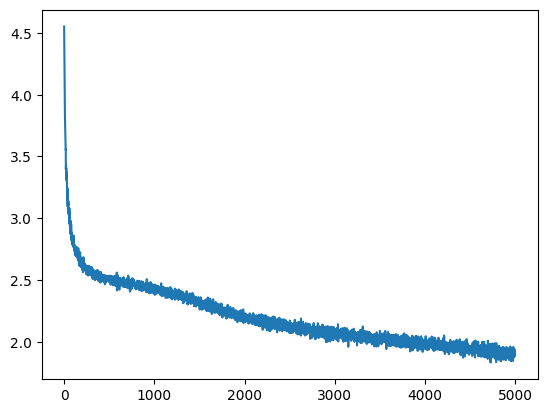

In [13]:
plt.plot(train_losses);

In [14]:
print("------\nAfter optimization:")
print(train_losses[-1])
print(decode(model.generate(torch.zeros((1, 1), dtype=torch.long, device=device), max_new_tokens=1000)[0].tolist()))

------
After optimization:
1.9153251647949219

And lostize in ded a onor light of oursir
Bostall oar nayge in a goone.

MEO:

DUKE ERSAher:
No now your QUEELHZEL:
Thu and tow fart grebead meakigh, My the hin
Oncly the why shat to marty
I' nas, eard of or and with; hen I whos in to samard.
Hen they noth of 'have. Bon in thy we ere thou this he buddaritht
go incmatis.

MANGIULES:
No, itt band, mat morkh man, anking ba Vinght.
Northatisell to of it! Prea,
Whee that thou sonme wor?

QUEEN ESTHEENRYCUSTIINR:

Hord no blonearn thair, w thate hip cortescheen ances bo

Farterh:
Whe that thear set I somplecce.

PEightaleim:
By thim houg! Nowlded, him or crain my on, Marrait,

GINGAUWI:
Wherat nobod shom selar:
He buttany dis hour hiegnie to freeft
Hineard you, ryou tulde.
LUORD:
By manot it seair'd
Dor's geavinchis in upor I arfout: bemood yone?
O, thank that Pevance folltch digh mearl
Conthours ady's hoplastaliel?
Thinh no arnd wotclfos his Rome;
Ralf:
astil; nhis thy not do retatio must min.
